In [1]:
import yaml
import scipy.io as sio
import numpy as  np
from skimage.data import shepp_logan_phantom

In [2]:
# load the data
with open("../data_loc.yaml", "r") as f:
    data_file = yaml.safe_load(f)

raw_data = sio.loadmat(data_file)

xtrue = shepp_logan_phantom()
xtrue = xtrue[8:-8, 8:-8]
sensitivity_maps = np.transpose(raw_data["b1"], (2, 0, 1))
coil_images = sensitivity_maps * xtrue[None, :, :]

In [3]:
import torch
from torchkbnufft import KbNufft

# extract the k-space trajectory
ktraj = raw_data["k"]

# build the NUFFT object
nufft_ob =KbNufft(im_size=(xtrue.shape[-2], xtrue.shape[-1]))

# torchkbnufft expects ktraj in radians/voxel
ktraj_torch = ktraj * 2 * np.pi
# stack the spatial dimensions instead of have real/imag
ktraj_torch = np.stack((np.real(ktraj_torch), np.imag(ktraj_torch)))

# convert to PyTorch tensor
ktraj_torch = torch.tensor(ktraj_torch, dtype=torch.float32).reshape(2, -1).contiguous()
# PyTorch expects batch dimension
coil_images_torch = torch.tensor(xtrue, dtype=torch.complex64).unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    data = nufft_ob(coil_images_torch, ktraj_torch)
print(data.shape)

torch.Size([1, 1, 460800])


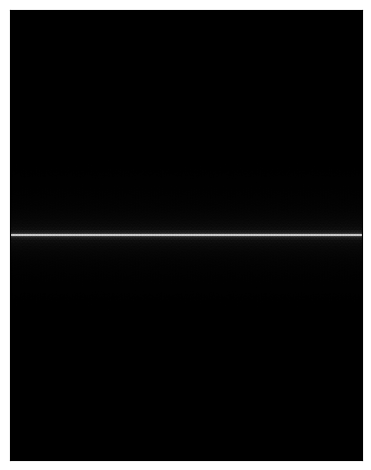

In [4]:
import matplotlib.pyplot as plt
plt.imshow(np.absolute(data[0, 0].reshape(768, 600).numpy()))
plt.xticks([])
plt.yticks([])
plt.gray()
plt.tight_layout()
plt.show()

In [5]:
from torchkbnufft import KbNufftAdjoint

# instantiate adjoint object
adj_ob = KbNufftAdjoint(im_size=(xtrue.shape[-2], xtrue.shape[-1]))

# run the adjoint
recon_image = adj_ob(data, ktraj_torch)
print(recon_image.shape)

torch.Size([1, 1, 384, 384])


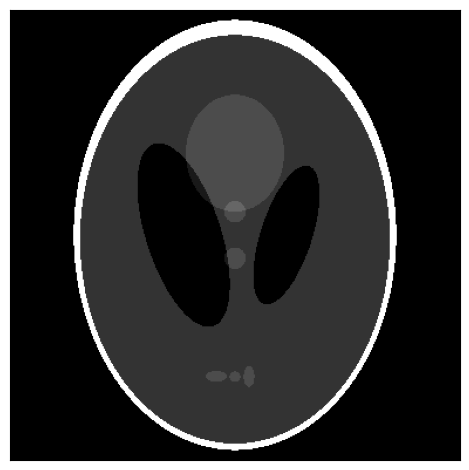

In [8]:
plt.imshow(np.absolute(coil_images_torch[0][0].numpy()))
plt.xticks([])
plt.yticks([])
plt.gray()
plt.tight_layout()
plt.show()

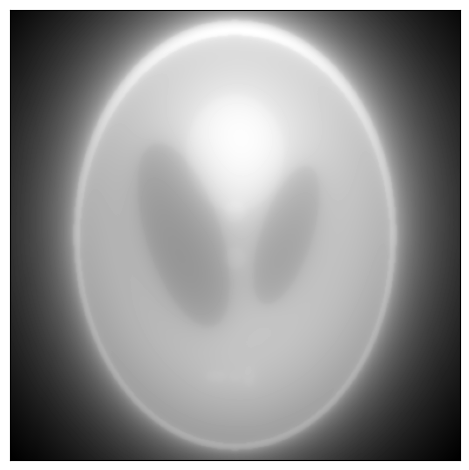

In [6]:
plt.imshow(np.absolute(recon_image[0][0].numpy()))
plt.xticks([])
plt.yticks([])
plt.gray()
plt.tight_layout()
plt.show()

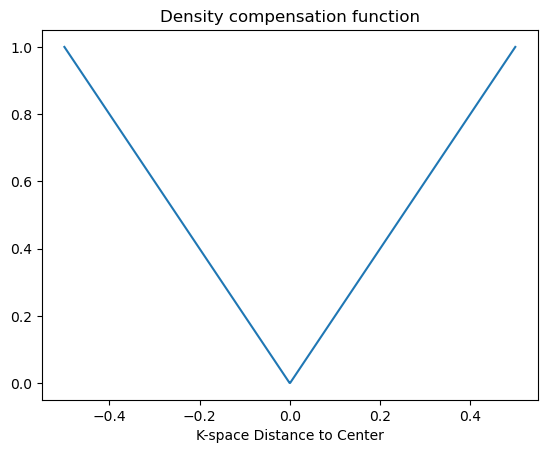

In [14]:
plt.figure(0)
x_vals = np.imag(raw_data["k"][:, 0])
plt.plot(x_vals, raw_data["w"][:, 0])
plt.title("Density compensation function")
plt.xlabel("K-space Distance to Center")
plt.show()

In [19]:
# pull out density compensation, unsqueeze batch/coil dimension
dcomp = torch.tensor(raw_data["w"], dtype=torch.float32).reshape(1, 1, -1)

# reconstruct with density compensation
recon_image = adj_ob(dcomp * data, ktraj_torch)

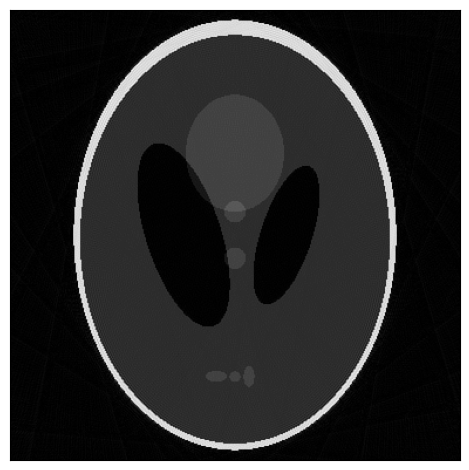

In [20]:
plt.imshow(np.absolute(recon_image[0][0].numpy()))
plt.xticks([])
plt.yticks([])
plt.gray()
plt.tight_layout()
plt.show()